In [274]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [2]:
import deeptriplet.models
import deeptriplet.datasets

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


## Load VOC2012 dataset

In [319]:
valset = deeptriplet.datasets.PascalDataset(pascal_root="/scratch/yardima/datasets/voc12/VOCdevkit/VOC2012",
                                            split_file="/home/yardima/Python/experiments/pascal_split/val_obj.txt",
                                            normalize_imagenet=True,
                                            augment=False,
                                            pad_zeros=True,
                                            downsample_label=1)

valloader = data.DataLoader(valset,
                                batch_size=1,
                                num_workers=2,
                                shuffle=True)

trainset = deeptriplet.datasets.PascalDataset(pascal_root="/scratch/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt",
                        normalize_imagenet=True,
                        augment=True,
                        pad_zeros=True,
                        downsample_label=8,
                        scale_low=0.8,
                        scale_high=1.2)

trainloader = data.DataLoader(trainset,
                                batch_size=10,
                                num_workers=4,
                                shuffle=True)

## Load trained embedding model

In [239]:
model_path_random = "/srv/glusterfs/yardima/runs/deeplabv2/lfov-triplet/run_8/models/class-vgg-pascal_epoch-49.pth"

In [240]:
d1 = torch.load(model_path_random, map_location=lambda storage, loc: storage)

In [243]:
net = deeptriplet.models.DeepLab_VGG(n_classes=45)
net = net.cuda()
net.load_state_dict(d1)

In [244]:
net = net.eval().cuda();

## t-SNE samples

In [245]:
import sklearn.manifold

In [246]:
def produce_tsne(net, image, label):
    label_original = label.data.numpy().copy()
    label_original[label_original==255] = 0
    image = image.unsqueeze(0)
    label = label.unsqueeze(0)
    
    fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))

    
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
        #embeddings = out.cpu().data.numpy()
        embeddings = fc8_interp_test(out).cpu()
        
    embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
    labels = label.reshape(-1)
    
    embeddings = embeddings[labels != 255, :]
    labels = labels[labels != 255]

    
    ix = np.random.randint(low=0, high=embeddings.shape[0], size=(500,))
    embeddings_subset = embeddings[ix, :]
    labels_subset = labels[ix]
    
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(embeddings_subset)
    
    plt.figure(figsize=(12,4))

    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]))

    plt.subplot(1, 3, 2)
    plt.imshow(label_original.reshape(image.shape[2], image.shape[3]))

    plt.subplot(1, 3, 3)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_subset)
    
    out = fc8_interp_test(out).data.cpu().numpy()

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functio

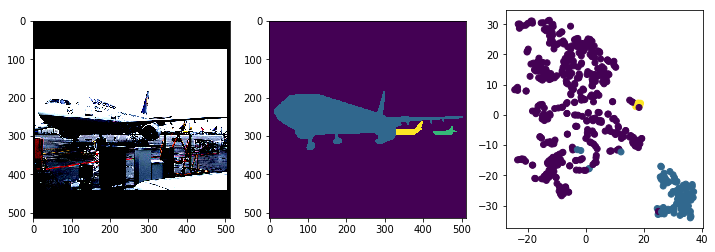

In [247]:
image, label = valset[0]
produce_tsne(net, image, label)

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


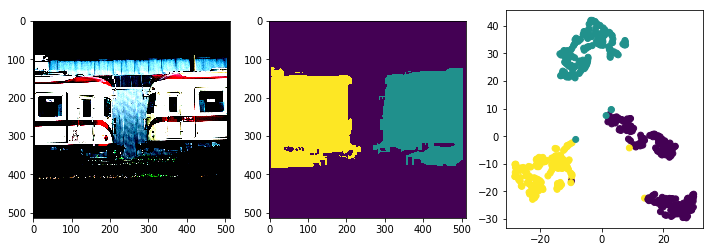

In [248]:
image, label = valset[1]
produce_tsne(net, image, label)

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


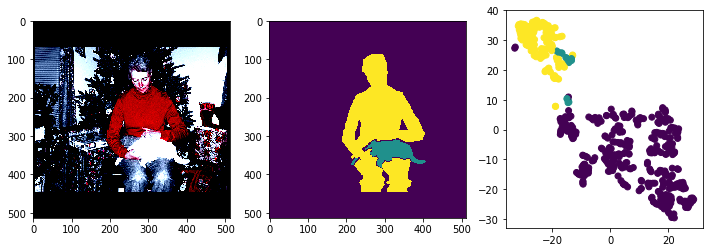

In [249]:
image, label = valset[100]
produce_tsne(net, image, label)

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


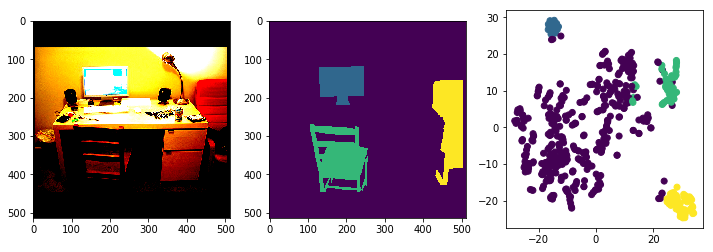

In [250]:
image, label = valset[150]
produce_tsne(net, image, label)

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


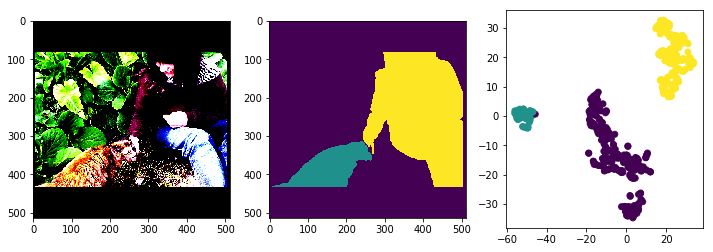

In [251]:
image, label = valset[190]
produce_tsne(net, image, label)

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


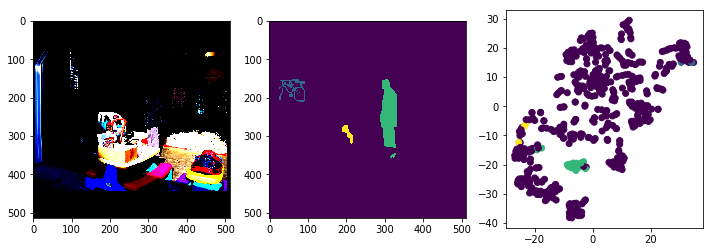

In [252]:
image, label = valset[195]
produce_tsne(net, image, label)

## Color projections

In [18]:
def rvs(dim=3):
    random_state = np.random
    H = np.eye(dim)
    D = np.ones((dim,))
    for n in range(1, dim):
        x = random_state.normal(size=(dim-n+1,))
        D[n-1] = np.sign(x[0])
        x[0] -= D[n-1]*np.sqrt((x*x).sum())
        # Householder transformation
        Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
        mat = np.eye(dim)
        mat[n-1:, n-1:] = Hx
        H = np.dot(H, mat)
        # Fix the last sign such that the determinant is 1
    D[-1] = (-1)**(1-(dim % 2))*D.prod()
    # Equivalent to np.dot(np.diag(D), H) but faster, apparently
    H = (D*H.T).T
    return H

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


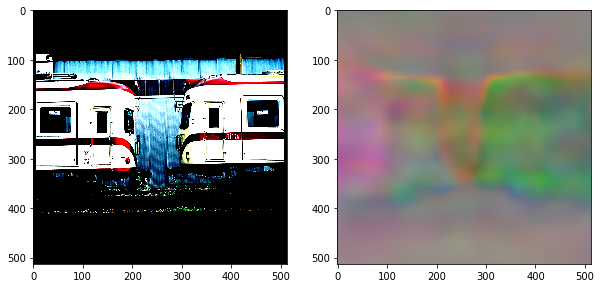

In [19]:
image, label = valset[1]

label_original = label.data.numpy().copy()
label_original[label_original==255] = 0

image = image.unsqueeze(0)
label = label.unsqueeze(0)

fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))

with torch.no_grad():
    image = image.cuda()
    out = net.forward(image)
    #embeddings = out.cpu().data.numpy()
    embeddings = fc8_interp_test(out).cpu()
    
rvo = rvs(21)[:3,:].T
embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
embeddings3 = np.matmul(embeddings, rvo)
embeddings3 = embeddings3.reshape(label.shape[1], label.shape[2], -1)
embeddings3
embeddings3.shape

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]))

plt.subplot(1, 2, 2)
plt.imshow(embeddings3 / 1.6 + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


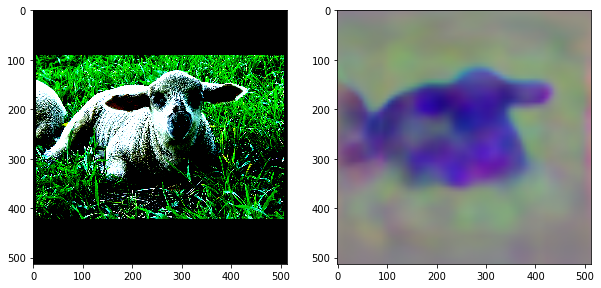

In [31]:
image, label = valset[5]

label_original = label.data.numpy().copy()
label_original[label_original==255] = 0

image = image.unsqueeze(0)
label = label.unsqueeze(0)

fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))

with torch.no_grad():
    image = image.cuda()
    out = net.forward(image)
    #embeddings = out.cpu().data.numpy()
    embeddings = fc8_interp_test(out).cpu()
    
rvo = rvs(21)[:3,:].T
embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
embeddings3 = np.matmul(embeddings, rvo)
embeddings3 = embeddings3.reshape(label.shape[1], label.shape[2], -1)
embeddings3
embeddings3.shape

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]))

plt.subplot(1, 2, 2)
plt.imshow(embeddings3 / 1.6 + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


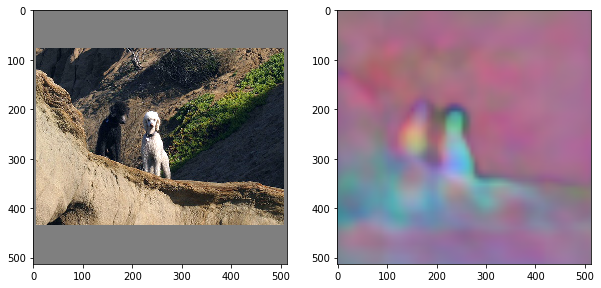

In [32]:
image, label = valset[101]

label_original = label.data.numpy().copy()
label_original[label_original==255] = 0

image = image.unsqueeze(0)
label = label.unsqueeze(0)

fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))

with torch.no_grad():
    image = image.cuda()
    out = net.forward(image)
    #embeddings = out.cpu().data.numpy()
    embeddings = fc8_interp_test(out).cpu()
    
rvo = rvs(21)[:3,:].T
embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
embeddings3 = np.matmul(embeddings, rvo)
embeddings3 = embeddings3.reshape(label.shape[1], label.shape[2], -1)
embeddings3
embeddings3.shape

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]) / 4 + 0.5)

plt.subplot(1, 2, 2)
plt.imshow(embeddings3 / 1.6 + 0.5)

(array([ 21175., 114167., 175224., 157601.,  94046., 184909.,  31325.,
          8382.,   2256.,    422.]),
 array([-0.42875512, -0.33613603, -0.24351694, -0.15089784, -0.05827875,
         0.03434034,  0.12695943,  0.21957853,  0.31219762,  0.40481671,
         0.4974358 ]),
 <a list of 10 Patch objects>)

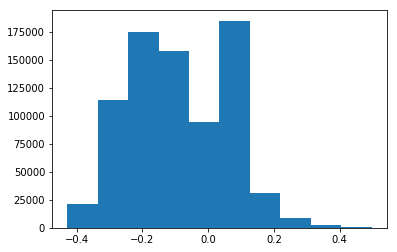

In [22]:
plt.hist(embeddings3.reshape(-1))

## Click-precision graph

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
def _fast_hist(label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask],
            minlength=n_class ** 2,
        ).reshape(n_class, n_class)
        return hist

In [54]:
import scipy.ndimage.morphology as morph

In [102]:
def run_clicks(embeddings, labels, clicks, flat=True):
    dim1, dim2 = labels.squeeze().shape
    
    if not flat:
        clicks = np.array([c[0] * dim2 + c[1] for c in clicks], dtype=np.int32)
        embeddings = embeddings.reshape(dim1 * dim2, -1)
        labels = labels.reshape(-1)
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(embeddings[clicks,:], labels[clicks])

    pred = knn.predict(embeddings)

    cf_matrix = _fast_hist(labels, pred, 2)

    iou = cf_matrix[1,1] / (cf_matrix[0,1] + cf_matrix[1,1] + cf_matrix[1,0])
    acc = np.sum(labels == pred) / len(labels)

    return pred.reshape(dim1,dim2), cf_matrix, iou, acc

In [268]:
def simulate_clicks(model, image, label, n_clicks):
    
    def run_clicks(embeddings, labels, clicks, flat=True):
        dim1, dim2 = labels.squeeze().shape

        if not flat:
            clicks = np.array([c[0] * dim2 + c[1] for c in clicks], dtype=np.int32)
            
            embeddings = embeddings.reshape(dim1 * dim2, -1)
            labels = labels.reshape(-1)

        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(embeddings[clicks,:], labels[clicks])

        pred = knn.predict(embeddings)

        cf_matrix = _fast_hist(labels[valid], pred[valid], 2)

        iou = cf_matrix[1,1] / (cf_matrix[0,1] + cf_matrix[1,1] + cf_matrix[1,0])
        acc = np.sum(labels[valid] == pred[valid]) / len(valid)

        return {"pred":pred.reshape(dim1,dim2), 
                "cf":cf_matrix, 
                "iou":iou, 
                "acc":acc}
    
    
    def pick_click(mask):
        candidates = np.transpose(np.nonzero(mask))
        return candidates[np.random.randint(low=0, high=candidates.shape[0]), :]
    
    
    if image.dim() == 3:
        image = image.unsqueeze(0)
    
    if label.dim() == 2:
        label = label.unsqueeze(0)
        
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
        fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))
        out = fc8_interp_test(out)
        
        embeddings = out.cpu().data.numpy()
        embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
        label = label.data.numpy()

    d_margin = 20
    d_clicks = 40
        
    label = label.squeeze()
    border = label == 255
    valid = np.nonzero((label.reshape(-1) != 255))[0]
    border = morph.binary_dilation(border, iterations=d_margin)
    
    if len(np.unique(label * (1 - border))) > 1:
        o = np.random.choice(np.sort(np.unique(label * (1 - border)))[1:])
    else:
        return []
    
    label_obj = (label == o).astype(np.int32)
    
    if not np.any((1 - label_obj) * (1 - border)) or not np.any(label_obj * (1 - border)):
        return []

    click_map = np.zeros(shape=border.shape, dtype=np.int32)

    p1 = pick_click((label_obj) * (1 - border))
    n1 = pick_click((1 - label_obj) * (1 - border))

    click_map[max(p1[0]-d_clicks, 0):p1[0]+d_clicks, max(p1[1]-d_clicks,0):p1[1]+d_clicks] = 1
    click_map[max(n1[0]-d_clicks, 0):n1[0]+d_clicks, max(n1[1]-d_clicks,0):n1[1]+d_clicks] = 1

    clicks = [p1, n1]
    results = []
    results.append(run_clicks(embeddings, label_obj, clicks, flat=False))

    for i in range(2, n_clicks):
        
        if not np.any((1 - click_map) * (1 - border)):
            return results
        
        c = pick_click((1 - click_map) * (1 - border))
        click_map[max(c[0]-d_clicks, 0):c[0]+d_clicks, max(c[1]-d_clicks,0):c[1]+d_clicks] = 1
        
        clicks.append(c)
        
        results.append(run_clicks(embeddings, label_obj, clicks, flat=False))
        
    return results

In [324]:
import skimage.segmentation

def simulate_clicks_v2(model, image, label, n_clicks, *, d_clicks=40, d_margin=20):
    
    def run_clicks(embeddings, labels, clicks, flat=True):
        dim1, dim2 = labels.squeeze().shape

        if not flat:
            clicks = np.array([c[0] * dim2 + c[1] for c in clicks], dtype=np.int32)
            
            embeddings = embeddings.reshape(dim1 * dim2, -1)
            labels = labels.reshape(-1)

        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(embeddings[clicks,:], labels[clicks])

        pred = knn.predict(embeddings)

        cf_matrix = _fast_hist(labels[valid], pred[valid], 2)

        iou = cf_matrix[1,1] / (cf_matrix[0,1] + cf_matrix[1,1] + cf_matrix[1,0])
        acc = np.sum(labels[valid] == pred[valid]) / len(valid)

        return {"pred":pred.reshape(dim1,dim2), 
                "cf":cf_matrix, 
                "iou":iou, 
                "acc":acc}
    
    
    def pick_click(mask):
        candidates = np.transpose(np.nonzero(mask))
        return candidates[np.random.randint(low=0, high=candidates.shape[0]), :]
    
    
    if image.dim() == 3:
        image = image.unsqueeze(0)
    
    if label.dim() == 2:
        label = label.unsqueeze(0)
        
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
        fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))
        out = fc8_interp_test(out)
        
        embeddings = out.cpu().data.numpy()
        embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
        label = label.data.numpy()

    d_margin = 20
    d_clicks = 40
        
    label = label.squeeze()
    border = label == 255
    valid = np.nonzero((label.reshape(-1) != 255))[0]
    border2 = morph.binary_dilation(border, iterations=d_margin)
    
    if len(np.unique(label * (1 - border2))) > 1:
        o = np.random.choice(np.sort(np.unique(label * (1 - border2)))[1:])
    else:
        return []
    
    label_obj = (label == o).astype(np.int32)
    
    border = border + morph.binary_dilation(skimage.segmentation.find_boundaries(label_obj), iterations=d_margin)
    
    if not np.any((1 - label_obj) * (1 - border)) or not np.any(label_obj * (1 - border)):
        return []

    click_map = np.zeros(shape=border.shape, dtype=np.int32)

    p1 = pick_click((label_obj) * (1 - border))
    n1 = pick_click((1 - label_obj) * (1 - border))

    click_map[max(p1[0]-d_clicks, 0):p1[0]+d_clicks, max(p1[1]-d_clicks,0):p1[1]+d_clicks] = 1
    click_map[max(n1[0]-d_clicks, 0):n1[0]+d_clicks, max(n1[1]-d_clicks,0):n1[1]+d_clicks] = 1

    clicks = [p1, n1]
    results = []
    results.append(run_clicks(embeddings, label_obj, clicks, flat=False))

    for i in range(2, n_clicks):
        
        if not np.any((1 - click_map) * (1 - border)):
            return results
        
        c = pick_click((1 - click_map) * (1 - border))
        click_map[max(c[0]-d_clicks, 0):c[0]+d_clicks, max(c[1]-d_clicks,0):c[1]+d_clicks] = 1
        
        clicks.append(c)
        
        results.append(run_clicks(embeddings, label_obj, clicks, flat=False))
        
    return results

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<IPython.core.display.Javascript object>


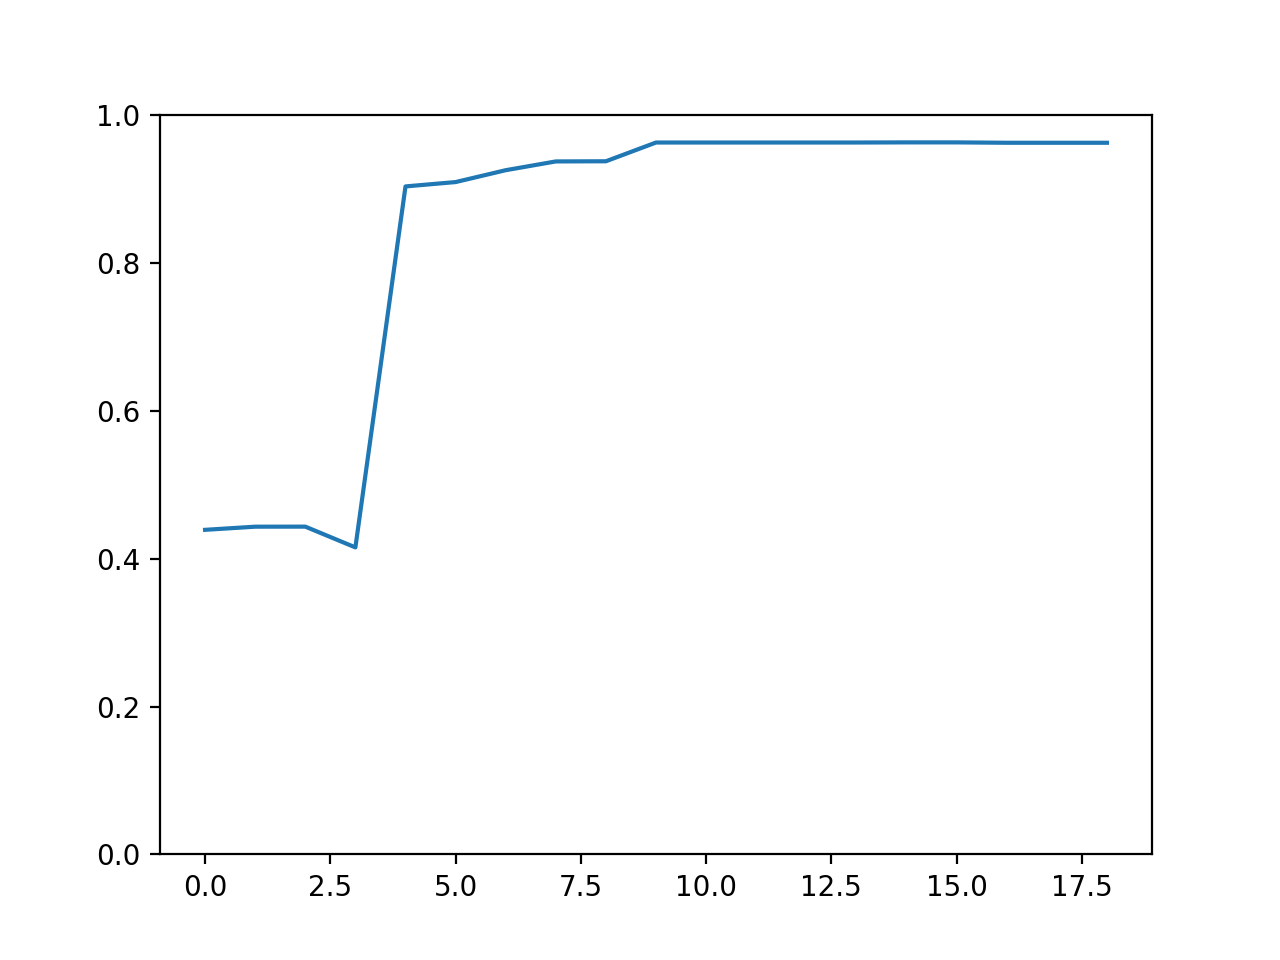

CPU times: user 6.66 s, sys: 916 ms, total: 7.57 s
Wall time: 8.51 s


In [321]:
%%time
image, label = valset[1]
results = simulate_clicks_v2(net, image, label, 20)
plt.figure()
plt.plot([r["iou"] for r in results])
plt.ylim(0, 1)

In [325]:
%%time
valiter = iter(valloader)
trials = 0

n_clicks = 20
mean_acc = np.zeros(n_clicks - 1)
mean_iou = np.zeros(n_clicks - 1)

for i in range(200):
    image, label = next(valiter)
    
    result = simulate_clicks_v2(net, image, label, n_clicks)

    if len(result) == n_clicks - 1:
        trials += 1

        mean_acc += np.array([r["acc"] for r in result])
        mean_iou += np.array([r["iou"] for r in result])
        
        print(trials)

mean_acc /= trials
mean_iou /= trials

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


1


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


3


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


4


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


5


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


6


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


7


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


8


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


9


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


10


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


11


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


12


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


13


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


14


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


15


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


16


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


17


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


18


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


19


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


20


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


21


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


22


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


23


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


24


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


25


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


26


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


27


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


28


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


29


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


30


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


31


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


32


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


33


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


34


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


35


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


36


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


37


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


38


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


39


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


40


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


41


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


42


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


43


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


44


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


45


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


46


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


47


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


48


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


49


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


50


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


51


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


52


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


53


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


54


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


55


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


56


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


57


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


58


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


59


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


60


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


61


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


62


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


63


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


64


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


65


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


66


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


67


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


68


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


69


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


70


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


71


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


72


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


73


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


74


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


75


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


76


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


77


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


78


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


79


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


80


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


81


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


82


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


83


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


84


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


85


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


86


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


87


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


88


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


89


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


90


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


91


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


92


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


93


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


94


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


95


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


96


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


97


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


98


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


99


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


100


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


101


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


102


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


103


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


104


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


105


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


106


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


107


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


108


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


109


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


110


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


111


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


112


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


113


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


114


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


115


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


116


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


117


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


118


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


119


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


120


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


121


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


122


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


123


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


124


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


125


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


126


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


127


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


128


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


129


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


130


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


131


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


132


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


133


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


134


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


135


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


136


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


137


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


138


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


139


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


140


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


141


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


142


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


143


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


144


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


145


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


146


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


147


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


148


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


149


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


150


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


151


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


152


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


153


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


154


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


155


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


156


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


157


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


158


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


159


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


160


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


161


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


162


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


163


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


164


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


165


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


166


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


167


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


168


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


169


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


170


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


171


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


172


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


173


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


174


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


175


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


176


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


177


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


178
CPU times: user 19min 28s, sys: 2min 58s, total: 22min 27s
Wall time: 59min 24s


<IPython.core.display.Javascript object>


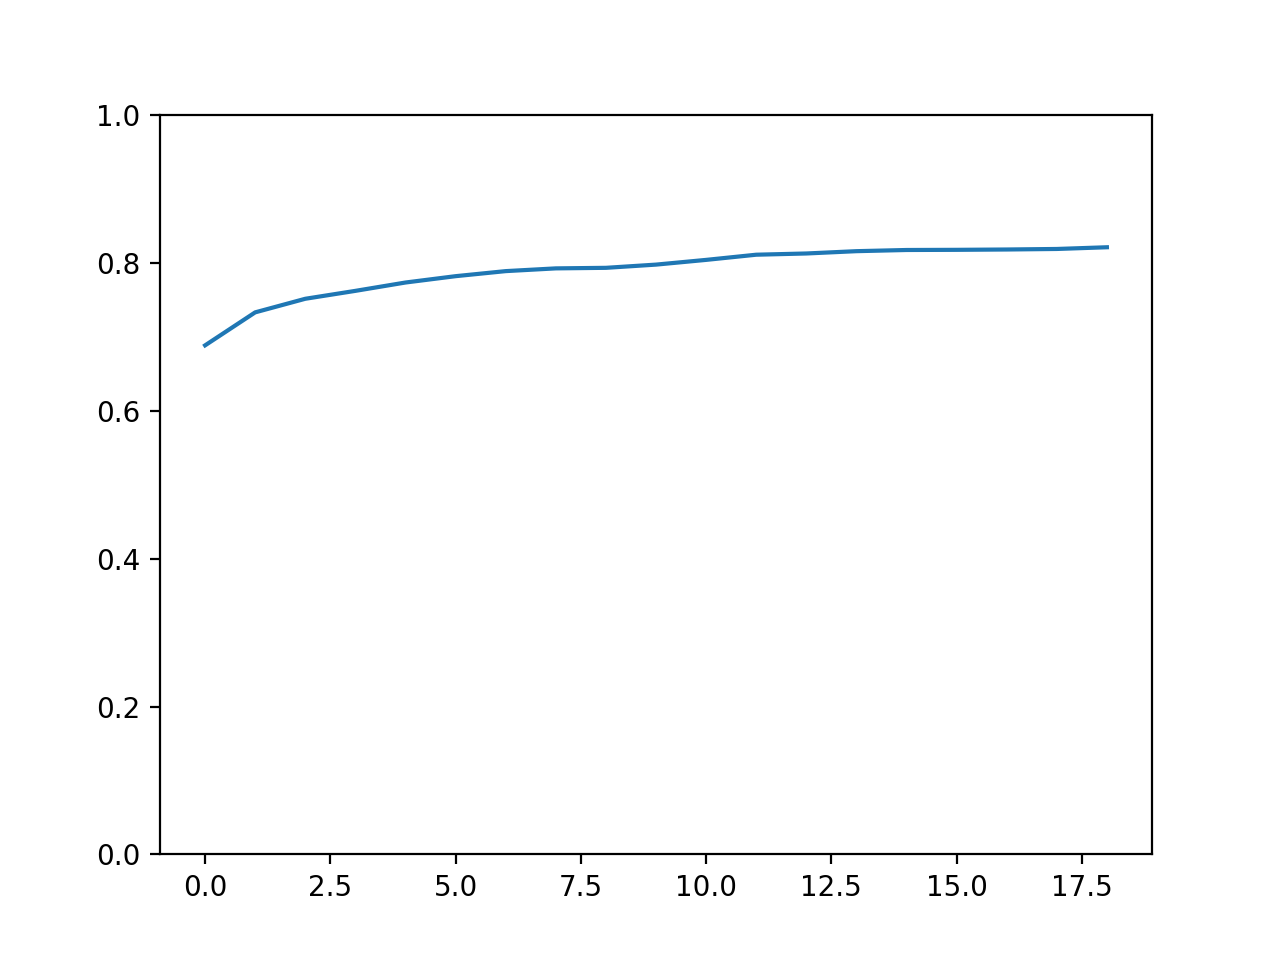

(0, 1)

In [326]:
plt.figure()
plt.plot(mean_iou)
plt.ylim(0,1)

In [266]:
image, label = valset[1]
image = image.unsqueeze(0)
label = label.unsqueeze(0)
with torch.no_grad():
    image = image.cuda()
    out = net.forward(image)
    print(image.shape)
    fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))
    out = fc8_interp_test(out)
    
    embeddings = out.cpu().data.numpy()
    embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
    label = label.data.numpy()


plt.figure(figsize=(18, 18))
plt.subplot(2,3,1)
plt.imshow(np.transpose(image.squeeze().data.cpu().numpy(), axes=[1, 2, 0]) / 4 + 0.5)
plt.subplot(2,3,2)
label2 = label.copy()
label2[label2 == 255] = 0
plt.imshow(label2.reshape(image.shape[2], image.shape[3]))

plt.subplot(2,3,3)

label = label.squeeze()
border = label == 255
border = morph.binary_dilation(border, iterations=d_margin)
plt.imshow(border)

o = np.random.choice(np.sort(np.unique(label * (1 - border)))[1:])

label = (label == o).astype(np.int32)

click_map = np.zeros(shape=border.shape, dtype=np.int32)

def pick_click(mask):
    candidates = np.transpose(np.nonzero(mask))
    return candidates[np.random.randint(low=0, high=candidates.shape[0]), :]
    
p1 = pick_click((label) * (1 - border))
n1 = pick_click((1 - label) * (1 - border))

d_margin = 20
d_clicks = 35

click_map[max(p1[0]-d_clicks, 0):p1[0]+d_clicks, max(p1[1]-d_clicks,0):p1[1]+d_clicks] = 1
click_map[max(n1[0]-d_clicks, 0):n1[0]+d_clicks, max(n1[1]-d_clicks,0):n1[1]+d_clicks] = 1

plt.subplot(2,3,4)
plt.imshow(click_map)

result = run_clicks(embeddings, label, [p1, n1], flat=False)

plt.subplot(2,3,5)
plt.imshow(pred)



array([0.73767135, 0.7631721 , 0.777656  , 0.79200661, 0.79661856,
       0.8015463 , 0.80793648, 0.8128886 , 0.82395793, 0.82946955,
       0.832834  , 0.83678062, 0.84023911, 0.84060427, 0.84257754,
       0.84235443, 0.84625579, 0.847451  , 0.84902684])

In [219]:
import skimage.transform